In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import linregress, t 
    
df_panel = pd.read_csv('panel_data_all_with_flu_rate.csv')
df_merged = pd.read_csv('df_merged.csv')
# df_merged = df_merged[df_merged['avg_users'] > 1000].reset_index(drop=True) #22
df_merged = df_merged[df_merged['user_rate'] > 0.5].reset_index(drop=True) #37
ciyt_list = df_merged['Country-city'].tolist()
print(ciyt_list)

# 强制转为数值，清理脏数据
df_panel['pm25'] = pd.to_numeric(df_panel['pm25'], errors='coerce')
df_panel['cough_rate'] = pd.to_numeric(df_panel['cough_rate'], errors='coerce')

# 删除缺失值
df_panel = df_panel.dropna(subset=['cough_rate', 'pm25', 'city', 'country'])

# 转换为 datetime 类型（必须）
df_panel['date'] = pd.to_datetime(df_panel['date'], errors='coerce')
df_panel['label'] = df_panel['country'] + '-' + df_panel['city']

# 提取城市
cities =  df_panel['label'].tolist()
ciyt_list = list(set(ciyt_list) & set(cities))
ciyt_list = sorted(ciyt_list)
print(len(ciyt_list))

df_panel = df_panel[df_panel['label'].isin(ciyt_list)]

['Australia-Brisbane', 'Australia-Melbourne', 'Australia-Sydney', 'Brazil-Sao Paulo', 'Chile-Santiago', 'China-Beijing', 'China-Chengdu', 'China-Hangzhou', 'China-Shanghai', 'France-Paris', 'Germany-Berlin', 'Germany-Leipzig', 'Italy-Bergamo', 'Italy-Florence', 'Italy-Milano', 'Italy-Monza and Brianza', 'Italy-Rome', 'Japan-Osaka', 'Japan-Tokyo', 'South Africa-City of Cape Town', 'South Africa-City of Johannesburg', 'Sweden-Uppsala', 'United Kingdom-Birmingham', 'United Kingdom-Cambridgeshire', 'United Kingdom-London', 'United Kingdom-Oxfordshire', 'United States-Chicago', 'United States-Columbus', 'United States-Los Angeles', 'United States-New York', 'United States-Phoenix', 'United States-Pittsburgh', 'United States-Saint Louis', 'United States-Salt Lake']
34


In [2]:
ciyt_list

['Australia-Brisbane',
 'Australia-Melbourne',
 'Australia-Sydney',
 'Brazil-Sao Paulo',
 'Chile-Santiago',
 'China-Beijing',
 'China-Chengdu',
 'China-Hangzhou',
 'China-Shanghai',
 'France-Paris',
 'Germany-Berlin',
 'Germany-Leipzig',
 'Italy-Bergamo',
 'Italy-Florence',
 'Italy-Milano',
 'Italy-Monza and Brianza',
 'Italy-Rome',
 'Japan-Osaka',
 'Japan-Tokyo',
 'South Africa-City of Cape Town',
 'South Africa-City of Johannesburg',
 'Sweden-Uppsala',
 'United Kingdom-Birmingham',
 'United Kingdom-Cambridgeshire',
 'United Kingdom-London',
 'United Kingdom-Oxfordshire',
 'United States-Chicago',
 'United States-Columbus',
 'United States-Los Angeles',
 'United States-New York',
 'United States-Phoenix',
 'United States-Pittsburgh',
 'United States-Saint Louis',
 'United States-Salt Lake']

In [3]:
# Nature-style 图像设置

plt.rcParams.update({
    "font.size": 8.5,
    "axes.titlesize": 9.0,
    "axes.labelsize": 8.5,
    "xtick.labelsize": 8.0,
    "ytick.labelsize": 8.0,
    "legend.fontsize": 8.0,
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "mathtext.default": "regular",
    "axes.linewidth": 0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
})


# Figure 2: GAM + non flu season correlation

C:\Users\xiato\AppData\Local\Temp\ipykernel_66948\1776440449.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["low_flu_month"] = df["low_flu_month"].fillna(False)
C:\Users\xiato\AppData\Local\Temp\ipykernel_66948\1776440449.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


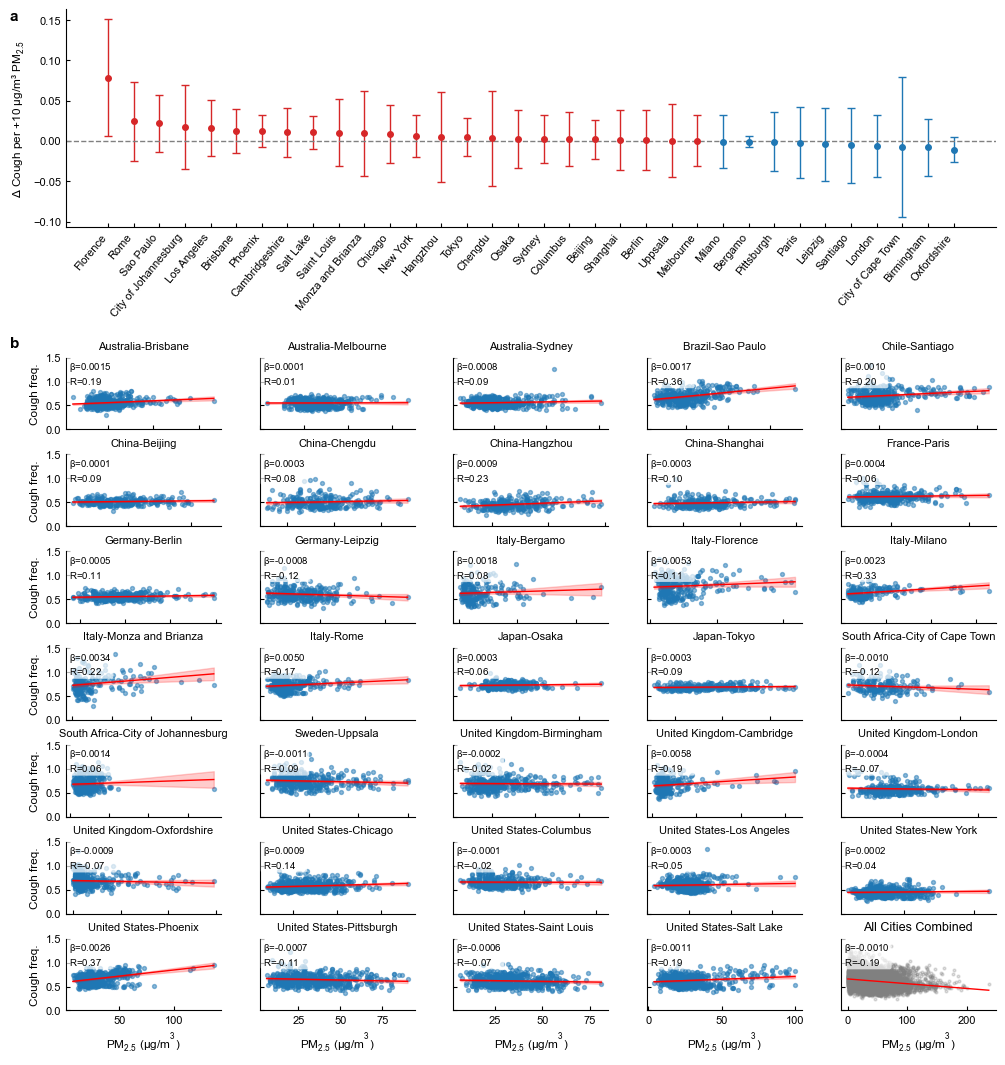

25 positive correlation among 34 cities


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
from pygam import LinearGAM, s, l



# ===================== (a) 森林图 =====================

# ========= 1) 数据准备 =========
df = df_panel.copy()
# 确保列名匹配：city, date, cough_rate, pm25, TAVG, PRCP, flu_rate
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['city', 'date']).copy()
# 为每个城市构造数值型时间索引（控制季节/长期趋势）
df['time_index'] = df.groupby('city')['date'].transform(lambda x: (x - x.min()).dt.days)

# ========= 2) 工具函数：兼容提取 pyGAM 的置信带 =========
def extract_ci(confi):
    """
    将 pyGAM.partial_dependence 返回的 CI，统一为 (lower, upper) 两个 1D 数组。
    兼容不同版本返回 (lower, upper)、array(n,2)、[array(n,2)] 等情况。
    """
    if isinstance(confi, (list, tuple)):
        if len(confi) == 2 and np.ndim(confi[0]) == 1:   # (lower, upper)
            return np.asarray(confi[0]), np.asarray(confi[1])
        elif len(confi) == 1:                            # [ array(n,2) ]
            ci = np.asarray(confi[0])
            return ci[:, 0], ci[:, 1]
        else:                                            # 兜底：当作 (n,2)
            ci = np.asarray(confi)
            return ci[:, 0], ci[:, 1]
    ci = np.asarray(confi)                               # 直接 ndarray
    if ci.ndim == 2 and ci.shape[1] == 2:
        return ci[:, 0], ci[:, 1]
    elif ci.ndim == 1:                                   # 少见：一维，拆半
        half = ci.size // 2
        return ci[:half], ci[half:]
    else:
        raise ValueError("Unrecognized CI format from pyGAM")

# ========= 3) 循环每个城市拟合：PM2.5 线性，其它平滑 =========
records = []

for city, sub in df.groupby('city'):
    sub = sub.dropna(subset=['cough_rate','pm25','TAVG','PRCP','flu_rate','time_index'])
    if len(sub) < 30:  # 数据太少时跳过（可自行调整）
        continue

    # 设计矩阵：列顺序要与下面的 l()/s() term 索引一致
    # 索引说明：0=pm25(线性)，1=TAVG(s)，2=PRCP(s)，3=time_index(s)，4=flu_rate(s)
    X = sub[['pm25','TAVG','PRCP','time_index','flu_rate']].values
    y = sub['cough_rate'].values

    # 拟合 GAM：PM2.5 线性项 + 其它平滑项
    gam = LinearGAM(
        l(0) +                  # 🔹PM2.5 线性项
        l(1) +
        l(2) +
        l(3) + 
        l(4)
        # s(1, n_splines=4) +     # TAVG 平滑
        # s(2, n_splines=4) +     # PRCP 平滑
        # s(3, n_splines=4) +     # 时间趋势平滑
        # s(4, n_splines=4)       # 流感平滑
    ).fit(X, y)

    # 在 pm25 上生成网格；其余特征固定在代表值（pyGAM会自动处理）
    XX = gam.generate_X_grid(term=0, n=200)  # shape: (200, 5)，只有第0列(pm25)在变化
    pdep, confi = gam.partial_dependence(term=0, X=XX, width=0.95)  # 仅PM2.5项的偏依赖
    lower, upper = extract_ci(confi)

    # 以该城市 pm25 的中位数为基点，计算 “+10 μg/m³ 的效应”
    pm_med = float(np.median(sub['pm25']))

    def interp(arr, x):
        return np.interp(x, XX[:, 0], arr)

    # 绝对变化量（单位与 cough_rate 一致）
    effect_10 = interp(pdep, pm_med + 10) - interp(pdep, pm_med)

    # 置信区间（保守近似：两端置信带的差）
    eff_lo = interp(lower, pm_med + 10) - interp(upper, pm_med)
    eff_hi = interp(upper, pm_med + 10) - interp(lower, pm_med)

    records.append({
        'city': city,
        'n_obs': len(sub),
        'pm25_median': pm_med,
        'effect_per_10': effect_10,
        'ci_lower': eff_lo,
        'ci_upper': eff_hi,
        'pseudo_r2': gam.statistics_['pseudo_r2']
    })

res = pd.DataFrame(records).sort_values('effect_per_10').reset_index(drop=True)
# ======= 预处理 =======
res_plot = res.sort_values('effect_per_10', ascending=False).reset_index(drop=True)
xpos = np.arange(len(res_plot))

# 误差条（左右）
yerr_lower = res_plot['effect_per_10'] - res_plot['ci_lower']
yerr_upper = res_plot['ci_upper'] - res_plot['effect_per_10']
yerr = np.vstack([yerr_lower, yerr_upper])

# 颜色映射：正值蓝色，负值红色（你可换为更温和配色）
colors = ['tab:red' if eff > 0 else 'tab:blue' for eff in res_plot['effect_per_10']]



# ---------- 画布与网格 ----------
fig = plt.figure(figsize=(12, 13))
gs = fig.add_gridspec(2, 1, height_ratios=[1,3], hspace=0.3)

ax1 = fig.add_subplot(gs[0])

res_plot = res.sort_values('effect_per_10', ascending=False).reset_index(drop=True)
xpos = np.arange(len(res_plot))
yerr_lower = res_plot['effect_per_10'] - res_plot['ci_lower']
yerr_upper = res_plot['ci_upper'] - res_plot['effect_per_10']
colors = ['tab:red' if eff > 0 else 'tab:blue' for eff in res_plot['effect_per_10']]

for i, (x, y, c) in enumerate(zip(xpos, res_plot['effect_per_10'], colors)):
    ax1.errorbar(x, y,
                 yerr=[[yerr_lower[i]], [yerr_upper[i]]],
                 fmt='o', color=c, capsize=3, markersize=4, linewidth=1)

ax1.axhline(0, linestyle='--', color='gray', linewidth=1)
ax1.set_xticks(xpos)
ax1.set_xticklabels(res_plot['city'], rotation=50, ha='right')
ax1.set_ylabel('Δ Cough per +10 μg/m³ PM$_{2.5}$')
#ax1.set_title('City-specific PM$_{2.5}$ effects on nocturnal cough (GAM, linear PM$_{2.5}$)')
for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)

# 子图角标 (a)
ax1.text(-0.06, 1, 'a', transform=ax1.transAxes, va='top', ha='left', fontsize=11, fontweight='bold')






# ===================== (b) 小面板散点 + 合并 =====================

df = df_panel.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# 1️⃣ 计算每个国家每月的平均 flu_rate
monthly_avg = df.groupby(["country", "year", "month"])["flu_rate"].mean().reset_index()
low_flu_months = monthly_avg[monthly_avg["flu_rate"] < 0.1][["country", "year", "month"]]

# 2️⃣ 将低流感月份标记回原数据
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df = df.merge(low_flu_months.assign(low_flu_month=True), on=["country", "year", "month"], how="left")
df["low_flu_month"] = df["low_flu_month"].fillna(False)

# 3️⃣ 筛选出低流感月份的数据
df_filtered = df[df["low_flu_month"]]


grid_cols = 5
# +1 为“合并所有城市”预留位置
grid_rows = int(np.ceil((len(ciyt_list) + 1) / grid_cols))
subgs = gs[1].subgridspec(grid_rows, grid_cols, wspace=0.25, hspace=0.35)

axes_grid = [fig.add_subplot(subgs[r, c]) for r in range(grid_rows) for c in range(grid_cols)]

# 统一轴范围（可选）：若想各城统一量程，更美观，打开下两行
UNIFY_Y = True
UNIFY_X = False

if UNIFY_Y:
    y_min, y_max = 0, 1.5  # 根据你的数据调整
if UNIFY_X:
    x_min = df_filtered['pm25'].min()
    x_max = df_filtered['pm25'].max()

positve_flag = 0
plot_i = 0

for i, city in enumerate(ciyt_list):
    # 预留最后一格给合并图
    if plot_i >= len(axes_grid) - 1:
        break

    ax = axes_grid[plot_i]
    df_city = df_filtered[df_filtered["label"] == city]
    x = df_city["pm25"].values
    y = df_city["cough_rate"].values
    n = len(x)

    if n < 100:
        ax.set_title(f"{city} (Insufficient data)", fontsize=8)
        ax.axis('off')
        plot_i += 1
        continue

    slope, intercept, r, p, stderr = linregress(x, y)
    x_pred = np.linspace(x.min(), x.max(), 120)
    y_pred = slope * x_pred + intercept
    residuals = y - (slope * x + intercept)
    t_val = t.ppf(0.975, df=n - 2)
    mean_x = np.mean(x)
    se = np.sqrt(np.sum(residuals ** 2) / (n - 2)) * np.sqrt(1 / n + (x_pred - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
    ci = t_val * se

    ax.scatter(x, y, s=8, alpha=0.5)
    ax.plot(x_pred, y_pred, color="red", lw=1)
    ax.fill_between(x_pred, y_pred - ci, y_pred + ci, color="red", alpha=0.2)

    # 统一轴范围（可选）
    if UNIFY_Y:
        ax.set_ylim(y_min, y_max)
    if UNIFY_X:
        ax.set_xlim(x_min, x_max)

    # 标题与角标
    city_name = city.replace("United Kingdom-Cambridgeshire", "United Kingdom-Cambridge")
    ax.set_title(city_name, fontsize=8)
    ax.text(0.02, 0.96, f"$\\beta$={slope:.4f}\n$R$={r:.2f}",
            transform=ax.transAxes, fontsize=7, va='top',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    # 仅最左列显示 y 轴标签；仅最后一行显示 x 轴标签
    col_idx = plot_i % grid_cols
    row_idx = plot_i // grid_cols
    if col_idx != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Cough freq.')

    if row_idx != grid_rows - 1:
        ax.set_xlabel('')
        ax.set_xticklabels([])  # 隐藏刻度标签以节省空间
    else:
        ax.set_xlabel('PM$_{2.5}$ ($\mu$g/m$^3$)')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    if slope > 0:
        positve_flag += 1

    plot_i += 1

# 关闭多余空格子（除最后一格留给合并图）
for j in range(plot_i, len(axes_grid) - 1):
    axes_grid[j].axis("off")

# ----- 最后一格：合并所有城市 -----
ax_all = axes_grid[-1]
df_all = df_filtered[df_filtered["label"].isin(ciyt_list)]
x_all = df_all["pm25"].values
y_all = df_all["cough_rate"].values
if len(x_all) > 2:
    slope, intercept, r, p, stderr = linregress(x_all, y_all)
    x_pred = np.linspace(x_all.min(), x_all.max(), 150)
    y_pred = slope * x_pred + intercept
    ax_all.scatter(x_all, y_all, s=4, alpha=0.25, color="gray")
    ax_all.plot(x_pred, y_pred, color="red", lw=1)
    ax_all.set_title("All Cities Combined", fontsize=9)
    ax_all.text(0.02, 0.96, f"$\\beta$={slope:.4f}\n$R$={r:.2f}",
                transform=ax_all.transAxes, fontsize=7, va='top',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
    if UNIFY_Y:
        ax_all.set_ylim(y_min, y_max)
    if UNIFY_X:
        ax_all.set_xlim(x_min, x_max)

    # ax_all.set_xlim(0, 1.5)
    # 只在左列/底行显示轴标签
    if (len(axes_grid) - 1) % grid_cols != 0:
        ax_all.set_ylabel('')
        ax_all.set_yticklabels([])
    else:
        ax_all.set_ylabel('Cough freq.')
    ax_all.set_xlabel('PM$_{2.5}$ ($\mu$g/m$^3$)')
else:
    ax_all.set_title("All Cities Combined (Insufficient data)", fontsize=9)
    ax_all.axis('off')

for spine in ['top', 'right']:
    ax_all.spines[spine].set_visible(False)

# 子图角标 (b)：放在下半区右上角
axes_grid[0].text(-0.36, 1.3, 'b', transform=axes_grid[0].transAxes,
                  va='top', ha='left', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("figure_combined_pretty.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(positve_flag, f'positive correlation among {len(ciyt_list)} cities')
